# Assignment 1

In [2]:
# #@title Mount your Google Drive
# # If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# # you can delete this cell which is specific to Google Colab. You may also
# # change the paths for data/logs in Arguments below.
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# #@title Link your assignment folder & install requirements
# #@markdown Enter the path to the assignment folder in your Google Drive
# # If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# # you can delete this cell which is specific to Google Colab. You may also
# # change the paths for data/logs in Arguments below.
# import sys
# import os
# import shutil
# import warnings

# folder = "Your path to assignment folder" #@param {type:"string"}
# !ln -Ts "$folder" /content/assignment 2> /dev/null

# # Add the assignment folder to Python path
# if '/content/assignment' not in sys.path:
#   sys.path.insert(0, '/content/assignment')

# # Check if CUDA is available
# import torch
# if not torch.cuda.is_available():
#   warnings.warn('CUDA is not available.')

### Running on GPU
For this assignment, it will be necessary to run your experiments on GPU. To make sure the notebook is running on GPU, you can change the notebook settings with
* (EN) `Edit > Notebook Settings`
* (FR) `Modifier > Paramètres du notebook`


In [1]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim
from torchvision.datasets import CIFAR10
from torchvision import transforms
from utils import seed_experiment, to_device, cross_entropy_loss, compute_accuracy
from config import get_config_parser
import json
from mlp import MLP
from resnet18 import ResNet18
from mlpmixer import MLPMixer
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Local Test
Before run the experiment, here are some local test cases you can run for sanity check

In [2]:
import unittest
import test
suite = unittest.TestLoader().loadTestsFromModule(test)
unittest.TextTestRunner(verbosity=2).run(suite)

test_linear_attributes (test.TestLinear) ... ok
test_linear_forward (test.TestLinear) ... ok
test_activation (test.TestMLP) ... ok
test_forward (test.TestMLP) ... ok
test_mlp (test.TestMLP) ... ok
test_mixer_block (test.TestMLPMixer) ... ok
test_mlpmixer (test.TestMLPMixer) ... ok
test_patch_emb (test.TestMLPMixer) ... ok
test_basic_block (test.TestResNet) ... ok
test_basic_block2 (test.TestResNet) ... ok
test_resnet (test.TestResNet) ... ok
test_ce_loss (test.TestUtils) ... ok

----------------------------------------------------------------------
Ran 12 tests in 0.738s

OK


<unittest.runner.TextTestResult run=12 errors=0 failures=0>

## Experiments

Below we define a few default arguments to get you started with your experiments. You are encouraged to modify the function `main_entry()`, as well as these arguments, to fit your needs (e.g. changing hyperparameters, the optimizer, adding regularizations).

In [3]:
# Main code entry. Train the model and save the logs
from main import train, evaluate
def main_entry(args):
    # Check for the device
    if (args.device == "cuda") and not torch.cuda.is_available():
        warnings.warn(
            "CUDA is not available, make that your environment is "
            "running on GPU (e.g. in the Notebook Settings in Google Colab). "
            'Forcing device="cpu".'
        )
        args.device = "cpu"

    if args.device == "cpu":
        warnings.warn(
            "You are about to run on CPU, and might run out of memory "
            "shortly. You can try setting batch_size=1 to reduce memory usage."
        )

    # Seed the experiment, for repeatability
    seed_experiment(args.seed)

    test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
    # For training, we add some augmentation. Networks are too powerful and would overfit.
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                        ])
    # Loading the training dataset. We need to split it into a training and validation part
    # We need to do a little trick because the validation set should not use the augmentation.
    train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    val_dataset = CIFAR10(root='./data', train=True, transform=test_transform, download=True)
    train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
    _, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

    # Loading the test set
    test_set = CIFAR10(root='./data', train=False, transform=test_transform, download=True)
    
    # Load model
    print(f'Build model {args.model.upper()}...')
    if args.model_config is not None:
        print(f'Loading model config from {args.model_config}')
        with open(args.model_config) as f:
            model_config = json.load(f)
    else:
        raise ValueError('Please provide a model config json')
    print(f'########## {args.model.upper()} CONFIG ################')
    for key, val in model_config.items():
        print(f'{key}:\t{val}')
    print('############################################')
    model_cls = {'mlp': MLP, 'resnet18': ResNet18, 'mlpmixer': MLPMixer}[args.model]
    model = model_cls(**model_config)
    model.to(args.device)
    
    # Optimizer
    if args.optimizer == "adamw":
        optimizer = optim.AdamW(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=args.lr, weight_decay=args.weight_decay
        )
    elif args.optimizer == "momentum":
        optimizer = optim.SGD(
            model.parameters(),
            lr=args.lr,
            momentum=args.momentum,
            weight_decay=args.weight_decay,
        )
    
    print(
        f"Initialized {args.model.upper()} model with {sum(p.numel() for p in model.parameters())} "
        f"total parameters, of which {sum(p.numel() for p in model.parameters() if p.requires_grad)} are learnable."
    )

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    train_times, valid_times = [], []
    
    # We define a set of data loaders that we can use for various purposes later.
    train_dataloader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
    valid_dataloader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    test_dataloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, drop_last=False, num_workers=4)
    for epoch in range(args.epochs):
        tqdm.write(f"====== Epoch {epoch} ======>")
        loss, acc, wall_time = train(epoch, model, train_dataloader, optimizer,args)
        train_losses.append(loss)
        train_accs.append(acc)
        train_times.append(wall_time)

        loss, acc, wall_time = evaluate(epoch, model, valid_dataloader,args)
        valid_losses.append(loss)
        valid_accs.append(acc)
        valid_times.append(wall_time)

    test_loss, test_acc, test_time = evaluate(
        epoch, model, test_dataloader, args, mode="test"
    )
    best_acc = max(valid_accs)
    print(f"===== Best validation Accuracy: {best_acc:.3f} =====>")

    # Save log if logdir provided
    if args.logdir is not None:
        print(f'Writing training logs to {args.logdir}...')
        os.makedirs(args.logdir, exist_ok=True)
        with open(os.path.join(args.logdir, 'results.json'), 'w') as f:
            f.write(json.dumps(
                {
                    "train_losses": train_losses,
                    "valid_losses": valid_losses,
                    "train_accs": train_accs,
                    "valid_accs": valid_accs,
                    "test_loss": test_loss,
                    "test_acc": test_acc
                },
                indent=4,
            ))
    
        # Visualize
        if args.visualize and args.model in ['resnet18', 'mlpmixer']:
            model.visualize(args.logdir)
    return best_acc

In [4]:
@dataclass
class Arguments:
  # Data
  batch_size: int = 128
  # Model
  model: str = 'mlp'  # [mlp, resnet18, mlpmixer]
  model_config: str = "./model_configs/mlp.json" # path to model config json file

  # Optimization
  optimizer: str = 'adamw'  # [sgd, momentum, adam, adamw]
  epochs: int = 15
  lr: float = 1e-3
  momentum: float = 0.9
  weight_decay: float = 5e-4

  # Experiment
  logdir: str = '/content/assignment/logs'
  seed: int = 42

  # Miscellaneous
  device: str = 'cuda'
  visualize : bool = False
  print_every: int = 80

### 4.2 - MLP

In [5]:
model = 'mlp'
for nl in ['relu', 'sigmoid', 'tanh']:
    config = Arguments(model=model,
                       model_config=f'./model_configs/{model}/{model}_{nl}.json',
                       epochs=15,
                       logdir=f'exps/{model}/{model}_{nl}')
    main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLP...
Loading model config from ./model_configs/mlp/mlp_relu.json
########## MLP CONFIG ################
input_size:	3072
hidden_sizes:	[1024, 512, 64, 64]
num_classes:	10
activation:	relu
############################################
Initialized MLP model with 3709194 total parameters, of which 3709194 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.46330
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.76476
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.92733
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.57829
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.49250
== [TRAIN] Epoch: 0, Accuracy: 0.358 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.73075
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.420 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.67533
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.60598
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.67155
[TRAIN] Epoch: 1, Iter: 240, Loss: 1.59

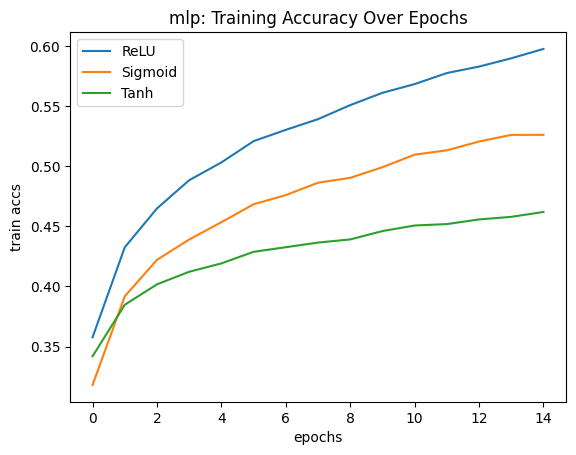

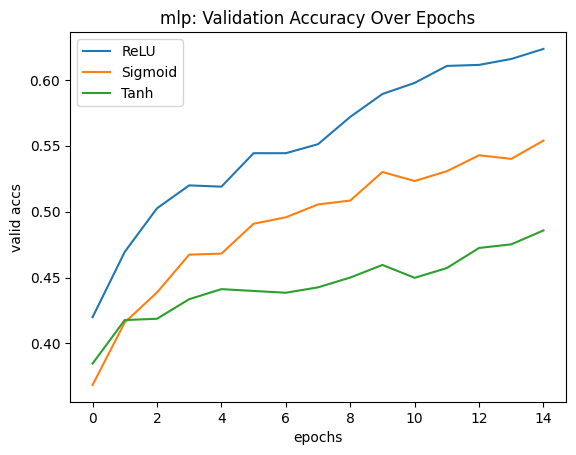

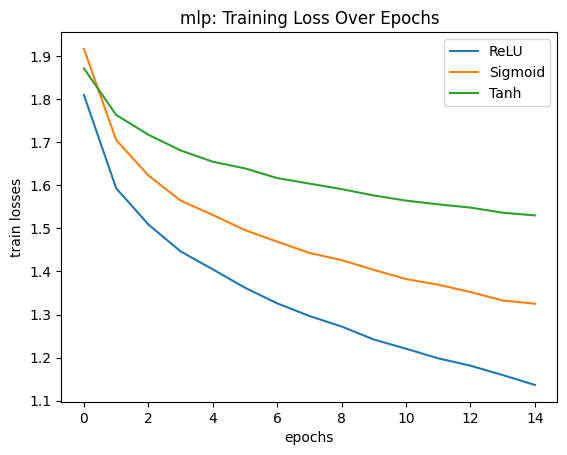

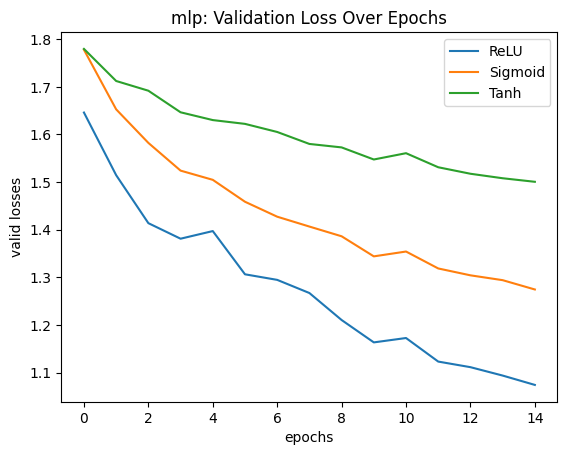

In [6]:
from utils import generate_plots
list_of_dirs = [f'exps/{model}/{model}_{nl}' for nl in ['relu', 'sigmoid', 'tanh']]
legend_names = ['ReLU', 'Sigmoid', 'Tanh']

mlp_fig = os.makedirs('results/mlp', exist_ok=True)

generate_plots(model, list_of_dirs, legend_names, 'results/mlp')

### 4.3 - resnet18

In [7]:
model2 = 'resnet18'
for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001]:
    config = Arguments(model=model2,
                       model_config=f'./model_configs/{model2}.json',
                       lr=lr,
                       optimizer='adam',
                       epochs=15,
                       logdir=f'exps/{model2}/{model2}_lr{lr}')
    main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: nan
[TRAIN] Epoch: 0, Iter: 160, Loss: nan
[TRAIN] Epoch: 0, Iter: 240, Loss: nan
[TRAIN] Epoch: 0, Iter: 320, Loss: nan
== [TRAIN] Epoch: 0, Accuracy: 0.100 ==>
[VAL] Epoch: 0, Iter: 0, Loss: nan
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.103 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: nan
[TRAIN] Epoch: 1, Iter: 80, Loss: nan
[TRAIN] Epoch: 1, Iter: 160, Loss: nan
[TRAIN] Epoch: 1, Iter: 240, Loss: nan
[TRAIN] Epoch: 1, Iter: 320, Loss: nan
== [TRAIN] Epoch: 1, Accuracy: 0.100 ==>
[VAL] E

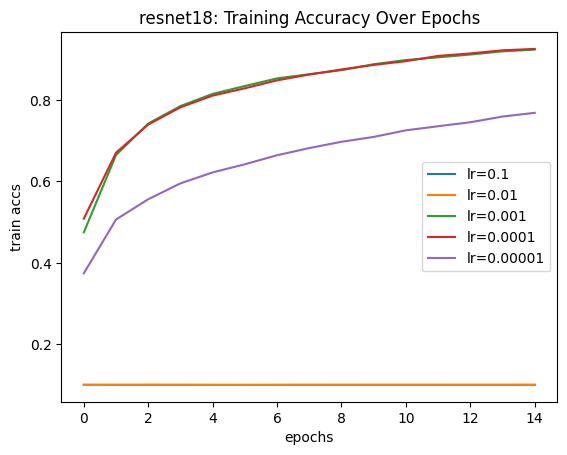

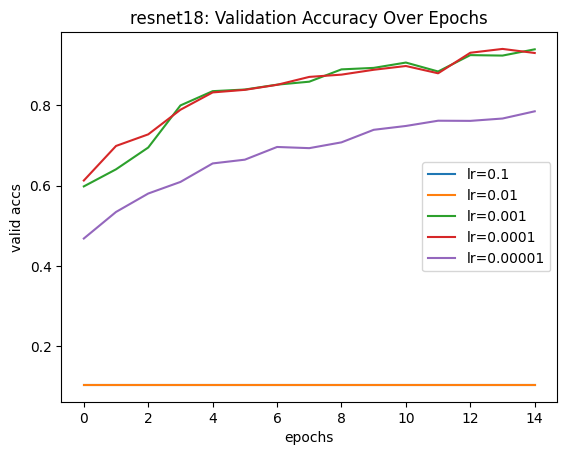

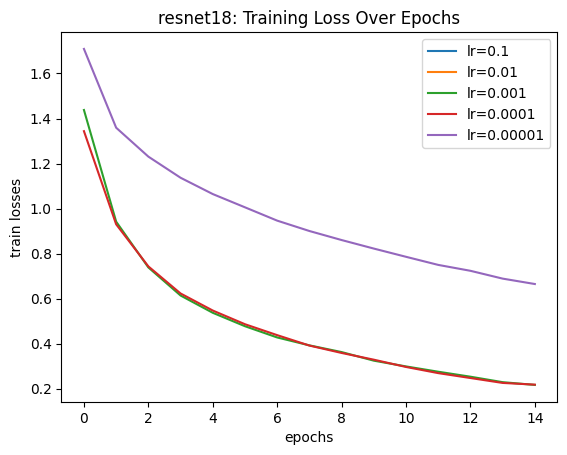

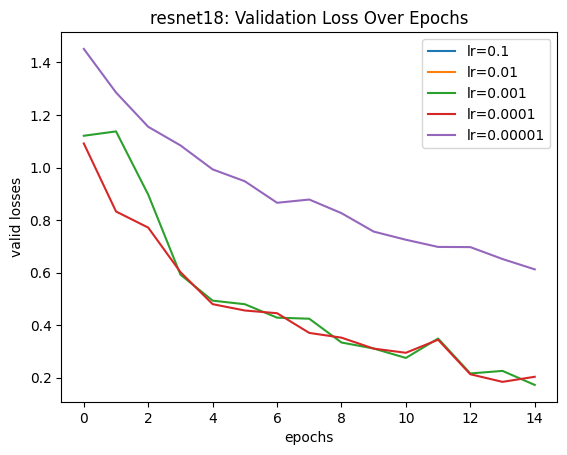

In [8]:
from utils import generate_plots
list_of_dirs = [f'exps/{model2}/{model2}_lr{lr}' for lr in [0.1, 0.01, 0.001, 0.0001, 0.00001]]
legend_names = ['lr=0.1', 'lr=0.01', 'lr=0.001', 'lr=0.0001', 'lr=0.00001']

resnet18_fig = os.makedirs(f'results/{model2}', exist_ok=True)

generate_plots(model2, list_of_dirs, legend_names, f'results/{model2}')

### 4.4 - MLPMixer

In [9]:
model3 = 'mlpmixer'
for ps in [4, 8, 16]:
    config = Arguments(model=model3,
                       model_config=f'./model_configs/{model3}/{model3}_ps{ps}.json',
                       epochs=15,
                       logdir=f'exps/{model3}/{model3}_ps{ps}')
    main_entry(config)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from ./model_configs/mlpmixer/mlpmixer_ps4.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	256
num_blocks:	4
drop_rate:	0.0
activation:	gelu
############################################
Initialized MLPMIXER model with 612362 total parameters, of which 612362 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.39691
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.78315
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.43121
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.51682
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.29731
== [TRAIN] Epoch: 0, Accuracy: 0.432 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.37619
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.552 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 1.22886
[TRAIN] Epoch: 1, Iter: 80, Loss: 1.31292
[TRAIN] Epoch: 1, Iter: 160, Loss: 1.131

[TRAIN] Epoch: 5, Iter: 320, Loss: 0.72436
== [TRAIN] Epoch: 5, Accuracy: 0.703 ==>
[VAL] Epoch: 5, Iter: 0, Loss: 0.89021
=== [VAL] Epoch: 5, Iter: 39, Accuracy: 0.702 ===>
====== Epoch 6 ======>
[TRAIN] Epoch: 6, Iter: 0, Loss: 0.70617
[TRAIN] Epoch: 6, Iter: 80, Loss: 0.74823
[TRAIN] Epoch: 6, Iter: 160, Loss: 0.86619
[TRAIN] Epoch: 6, Iter: 240, Loss: 0.90272
[TRAIN] Epoch: 6, Iter: 320, Loss: 0.91234
== [TRAIN] Epoch: 6, Accuracy: 0.721 ==>
[VAL] Epoch: 6, Iter: 0, Loss: 0.86459
=== [VAL] Epoch: 6, Iter: 39, Accuracy: 0.748 ===>
====== Epoch 7 ======>
[TRAIN] Epoch: 7, Iter: 0, Loss: 0.70785
[TRAIN] Epoch: 7, Iter: 80, Loss: 0.87045
[TRAIN] Epoch: 7, Iter: 160, Loss: 0.95828
[TRAIN] Epoch: 7, Iter: 240, Loss: 0.69215
[TRAIN] Epoch: 7, Iter: 320, Loss: 0.74204
== [TRAIN] Epoch: 7, Accuracy: 0.737 ==>
[VAL] Epoch: 7, Iter: 0, Loss: 0.84723
=== [VAL] Epoch: 7, Iter: 39, Accuracy: 0.759 ===>
====== Epoch 8 ======>
[TRAIN] Epoch: 8, Iter: 0, Loss: 0.90314
[TRAIN] Epoch: 8, Iter: 80, Lo

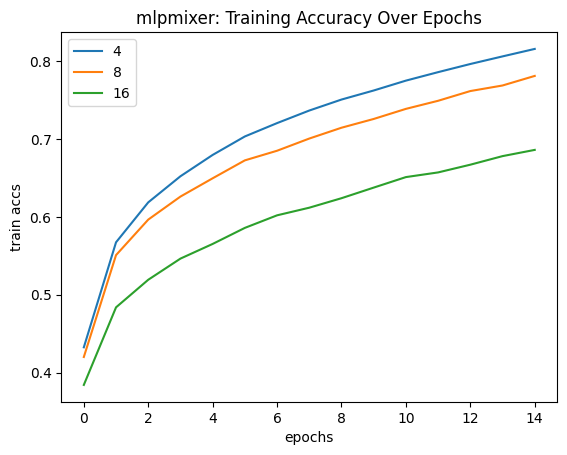

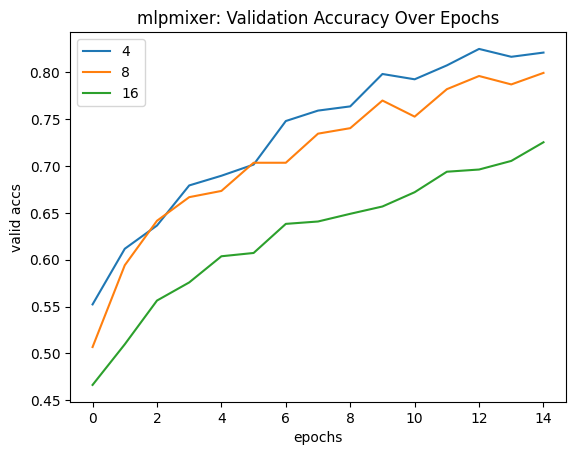

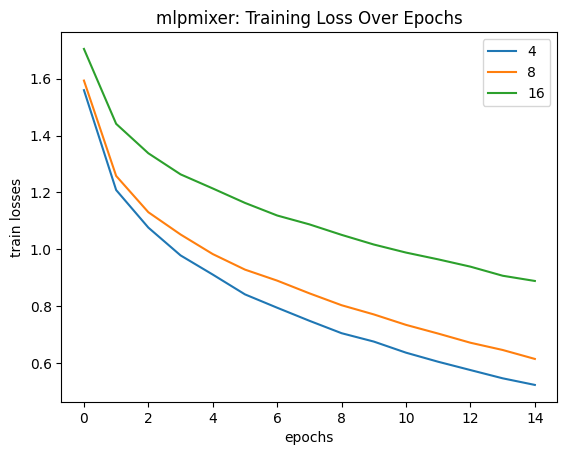

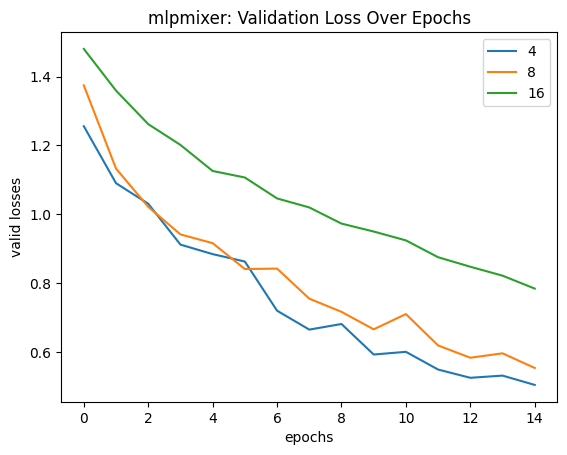

In [10]:
from utils import generate_plots
list_of_dirs = [f'exps/{model3}/{model3}_ps{ps}' for ps in [4, 8, 16]]
legend_names = ['4', '8', '16']

mlpmixer_fig = os.makedirs(f'results/{model3}', exist_ok=True)

generate_plots(model3, list_of_dirs, legend_names, f'results/{model3}')

### 4.5 Hyperparameter tuning for Resnet18

In [12]:
from itertools import product

# Define hyperparameter options
learning_rates = [0.001, 0.0001]
batch_sizes = [64, 128]
optimizers = ['adamw', 'sgd']
weight_decays = [1e-4, 1e-5]

best_model = None
best_acc = 0

# Run experiments
for lr, batch_size, optimizer, wd in product(learning_rates, batch_sizes, optimizers, weight_decays):
    config = Arguments(
        model='resnet18',
        model_config='./model_configs/resnet18.json',
        batch_size=batch_size,
        lr=lr,
        optimizer=optimizer,
        weight_decay=wd,
        logdir=f'exps/resnet18/lr{lr}_bs{batch_size}_opt{optimizer}_wd{wd}'
    )
    
    acc = main_entry(config)  # Train and evaluate
    
    if acc > best_acc:
        best_acc = acc
        best_model = config

print(f"Best Model: {best_model}, with best accuracy: {best_acc}")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.38576
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.77514
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.37001
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.30852
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.43436
[TRAIN] Epoch: 0, Iter: 400, Loss: 1.25626
[TRAIN] Epoch: 0, Iter: 480, Loss: 1.30961
[TRAIN] Epoch: 0, Iter: 560, Loss: 1.17660
[TRAIN] Epoch: 0, Iter: 640, Loss: 1.08503
== [TRAIN] Epoch: 0, Accuracy: 0.498 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.20921
=== [VAL] Epoch: 0, Iter: 78, Accuracy: 0.615 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.87301
[TRAIN]

In [38]:
resnet18_best = 'resnet18'
config_resnet18_best = Arguments(
        model=resnet18_best,
        model_config='./model_configs/resnet18.json',
        batch_size=128,
        lr=0.0001,
        optimizer='adamw',
        weight_decay=0.0001,
        logdir=f'exps/resnet18/best_lr0.0001_bs128_optadamw_wd0.0001'
    )
restnet18_best_acc = main_entry(config_resnet18_best)
print(restnet18_best_acc)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model RESNET18...
Loading model config from ./model_configs/resnet18.json
########## RESNET18 CONFIG ################
num_classes:	10
############################################
Initialized RESNET18 model with 11173962 total parameters, of which 11173962 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.35367
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.45134
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.51728
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.17667
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.12790
== [TRAIN] Epoch: 0, Accuracy: 0.510 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.18419
=== [VAL] Epoch: 0, Iter: 39, Accuracy: 0.608 ===>
====== Epoch 1 ======>
[TRAIN] Epoch: 1, Iter: 0, Loss: 0.96078
[TRAIN] Epoch: 1, Iter: 80, Loss: 0.88035
[TRAIN] Epoch: 1, Iter: 160, Loss: 0.88854
[TRAIN] Epoch: 1, Iter: 240, Loss: 0.84281
[TRAIN] Epoch: 1, Iter: 320, Loss: 0.74812
== [TRAI

In [23]:
# Visualize first layer kernels
model.visualize(logdir='exps/resnet18/best_lr0.0001_bs128_optadamw_wd0.0001.pth', layer_name='conv1')

Kernel visualization saved to exps/resnet18/best_lr0.0001_bs128_optadamw_wd0.0001.pth/conv1_kernels.png


#### 4.6 Hyperparameter tuning of MlpMixer

In [8]:
# import torch
# import json
# import os
from config import get_config_parser

def find_best_mlpmixer_hyperparameters():
    """
    Experiment to find the best hyperparameters for MLPMixer
    """
    # Define a grid of hyperparameters to explore
    hyperparameter_grid = [
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 256,
            "num_blocks": 8,
            "drop_rate": 0.1,
            "activation": "gelu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 512,
            "num_blocks": 6,
            "drop_rate": 0.2,
            "activation": "gelu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 384,
            "num_blocks": 5,
            "drop_rate": 0.15,
            "activation": "relu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 384,
            "num_blocks": 5,
            "drop_rate": 0.15,
            "activation": "relu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 256,
            "num_blocks": 5,
            "drop_rate": 0.2,
            "activation": "relu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 384,
            "num_blocks": 5,
            "drop_rate": 0.2,
            "activation": "gelu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 384,
            "num_blocks": 10,
            "drop_rate": 0.25,
            "activation": "gelu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 384,
            "num_blocks": 10,
            "drop_rate": 0.15,
            "activation": "relu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 384,
            "num_blocks": 12,
            "drop_rate": 0.15,
            "activation": "gelu"
        },
        {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 256,
            "num_blocks": 10,
            "drop_rate": 0.25,
            "activation": "gelu"
        }
    ]

    # Create a results directory
    os.makedirs('exps/mlpmixer_hyperparameters', exist_ok=True)
    
    # Store results
    results = []

    # Argument parser setup
    parser = get_config_parser()
    args = parser.parse_args([
        '--model', 'mlpmixer', 
        '--model_config', 'temp_config.json',
        '--logdir', 'exps/mlpmixer_hyperparameters',
        '--epochs', '20',
        '--batch_size', '64',
        '--lr', '0.001',
        '--optimizer', 'adamw',
        '--device', 'cuda',
        '--visualize'
    ])

    # Run experiments
    for config in hyperparameter_grid:
        # Save temporary config
        with open('temp_config.json', 'w') as f:
            json.dump(config, f)
        
        # Run experiment
        best_accuracy = main_entry(args)
        
        # Record results
        config['best_accuracy'] = best_accuracy
        results.append(config)
        print(f"Config: {config}")

    # Save comprehensive results
    with open('exps/mlpmixer_hyperparameters/hyperparameter_search.json', 'w') as f:
        json.dump(results, f, indent=4)

    return results

find_best_mlpmixer_hyperparameters()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from temp_config.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	256
num_blocks:	8
drop_rate:	0.1
activation:	gelu
############################################
Initialized MLPMIXER model with 1209098 total parameters, of which 1209098 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.44593
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.84002
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.36839
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.57712
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.64748
[TRAIN] Epoch: 0, Iter: 400, Loss: 1.53377
[TRAIN] Epoch: 0, Iter: 480, Loss: 1.58086
[TRAIN] Epoch: 0, Iter: 560, Loss: 1.30888
[TRAIN] Epoch: 0, Iter: 640, Loss: 1.17447
== [TRAIN] Epoch: 0, Accuracy: 0.439 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.45677
=== [VAL] Epoch: 0, Iter: 78, Accuracy: 0.560 ===

[{'num_classes': 10,
  'img_size': 32,
  'patch_size': 4,
  'embed_dim': 256,
  'num_blocks': 8,
  'drop_rate': 0.1,
  'activation': 'gelu',
  'best_accuracy': 0.8862737341772144},
 {'num_classes': 10,
  'img_size': 32,
  'patch_size': 4,
  'embed_dim': 512,
  'num_blocks': 6,
  'drop_rate': 0.2,
  'activation': 'gelu',
  'best_accuracy': 0.8866693037974679},
 {'num_classes': 10,
  'img_size': 32,
  'patch_size': 4,
  'embed_dim': 384,
  'num_blocks': 5,
  'drop_rate': 0.15,
  'activation': 'relu',
  'best_accuracy': 0.8605617088607587},
 {'num_classes': 10,
  'img_size': 32,
  'patch_size': 4,
  'embed_dim': 384,
  'num_blocks': 5,
  'drop_rate': 0.15,
  'activation': 'relu',
  'best_accuracy': 0.8591772151898729},
 {'num_classes': 10,
  'img_size': 32,
  'patch_size': 4,
  'embed_dim': 256,
  'num_blocks': 5,
  'drop_rate': 0.2,
  'activation': 'relu',
  'best_accuracy': 0.8156645569620256},
 {'num_classes': 10,
  'img_size': 32,
  'patch_size': 4,
  'embed_dim': 384,
  'num_blocks':

In [24]:
# Load best configuration from previous experiment
with open('exps/mlpmixer_hyperparameters/hyperparameter_search.json', 'r') as f:
    configs = json.load(f)

# Select the best performing configuration
best_config = max(configs, key=lambda x: x['best_accuracy'])

print(best_config)

best_nc=best_config['num_classes'],
best_img=best_config['img_size'],
best_ps=best_config['patch_size'],
best_embed=best_config['embed_dim'],
best_nb=best_config['num_blocks'],
best_dr=best_config['drop_rate'],
best_act=best_config['activation']


mlpmixer_best = MLPMixer(
    num_classes=best_nc[0],
    img_size=best_img[0],
    patch_size=best_ps[0],
    embed_dim=best_embed[0],
    num_blocks=best_nb[0],
    drop_rate=best_dr[0],
    activation=best_act
)

# Visualize first layer kernels
mlpmixer_best.visualize(logdir=f'exps/mlpmixer_hyperparameters/best_embed{best_embed[0]}_nb{best_nb[0]}_dr{best_dr[0]}_act{best_act}.pth', layer_idx=0)

{'num_classes': 10, 'img_size': 32, 'patch_size': 4, 'embed_dim': 384, 'num_blocks': 10, 'drop_rate': 0.15, 'activation': 'relu', 'best_accuracy': 0.8955696202531641}
Visualization saved at exps/mlpmixer_hyperparameters/best_embed384_nb10_dr0.15_actrelu.pth/token_mixer_layer_0.png
Weight Matrix Shape: (192, 64)
Weight Statistics:
Mean: 0.49718538
Standard Deviation: 0.2887734
Min: 0.0
Max: 1.0


#### 4.7 Investigate widths varying of token_mixing and channel_mixing layers : MlpMixer

In [28]:
# Width configurations to explore
width_configs = [
    {
        "tokens_mlp_ratio": 0.25,  # Smaller width
        "channels_mlp_ratio": 0.5,
        "name": "Narrow_Layers"
    },
    {
        "tokens_mlp_ratio": 0.5,   # Medium width
        "channels_mlp_ratio": 1.0,
        "name": "Medium_Layers"
    },
    {
        "tokens_mlp_ratio": 1.0,   # Wide layers
        "channels_mlp_ratio": 2.0,
        "name": "Wide_Layers"
    },
    {
        "tokens_mlp_ratio": 2.0,   # Very wide layers
        "channels_mlp_ratio": 4.0,
        "name": "Very_Wide_Layers"
    }
]



def investigate_mlp_layer_widths(width_configs: list, save_investigation_dir: str):
    """
    Investigate the impact of token-mixing and channel-mixing MLP layer widths
    on MLPMixer model performance
    """
    # Create results directory
    os.makedirs(save_investigation_dir, exist_ok=True)
    

    # Argument parser setup
    parser = get_config_parser()
    args = parser.parse_args([
        '--model', 'mlpmixer', 
        '--model_config', 'temp_config.json',
        '--logdir', save_investigation_dir,
        '--epochs', '30',  # Increased epochs for more stable results
        '--batch_size', '64',
        '--lr', '0.001',
        '--optimizer', 'adamw',
        '--device', 'cuda'
    ])

    # Store comprehensive results
    comprehensive_results = []

    # Run experiments for each width configuration
    for config in width_configs:
        # Base MLPMixer configuration
        mlpmixer_config = {
            "num_classes": 10,
            "img_size": 32,
            "patch_size": 4,
            "embed_dim": 384,
            "num_blocks": 5,
            "drop_rate": 0.15,
            "activation": "gelu",
            "mlp_ratio": [config["tokens_mlp_ratio"], config["channels_mlp_ratio"]]
        }

        # Save temporary config
        with open('temp_config.json', 'w') as f:
            json.dump(mlpmixer_config, f)
        
        # Run experiment
        best_accuracy = main_entry(args)
        
        # Load detailed training logs
        with open(os.path.join(save_investigation_dir, 'results.json'), 'r') as f:
            training_logs = json.load(f)
        
        # Prepare results
        result = {
            "configuration_name": config["name"],
            "tokens_mlp_ratio": config["tokens_mlp_ratio"],
            "channels_mlp_ratio": config["channels_mlp_ratio"],
            "best_validation_accuracy": best_accuracy,
            "train_accuracies": training_logs["train_accs"],
            "validation_accuracies": training_logs["valid_accs"],
            "train_losses": training_logs["train_losses"],
            "validation_losses": training_logs["valid_losses"]
        }
        
        comprehensive_results.append(result)
        print(f"Configuration: {config['name']}, Best Accuracy: {best_accuracy}")

    # Save comprehensive results
    with open('exps/mlp_width_investigation/width_investigation_results.json', 'w') as f:
        json.dump(comprehensive_results, f, indent=4)
    

    return comprehensive_results


# Investigate the impact of token-mixing and channel-mixing MLP layer widths on MLPMixer model performance
investigate_mlp_layer_widths(width_configs, save_investigation_dir='exps/mlp_width_investigation')

# Plot comparison efficiency by layers type and analyse impacts of layer capacity on overfitting
comparison_efficiency_by_layer_type(comprehensive_results, logdir='exps/mlp_width_investigation/width_investigation_analysis.png')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Build model MLPMIXER...
Loading model config from temp_config.json
########## MLPMIXER CONFIG ################
num_classes:	10
img_size:	32
patch_size:	4
embed_dim:	384
num_blocks:	5
drop_rate:	0.15
activation:	gelu
mlp_ratio:	[0.25, 0.5]
############################################
Initialized MLPMIXER model with 833514 total parameters, of which 833514 are learnable.
====== Epoch 0 ======>
[TRAIN] Epoch: 0, Iter: 0, Loss: 2.47768
[TRAIN] Epoch: 0, Iter: 80, Loss: 1.85405
[TRAIN] Epoch: 0, Iter: 160, Loss: 1.48566
[TRAIN] Epoch: 0, Iter: 240, Loss: 1.65877
[TRAIN] Epoch: 0, Iter: 320, Loss: 1.43611
[TRAIN] Epoch: 0, Iter: 400, Loss: 1.31846
[TRAIN] Epoch: 0, Iter: 480, Loss: 1.16368
[TRAIN] Epoch: 0, Iter: 560, Loss: 1.40072
[TRAIN] Epoch: 0, Iter: 640, Loss: 1.27190
== [TRAIN] Epoch: 0, Accuracy: 0.426 ==>
[VAL] Epoch: 0, Iter: 0, Loss: 1.50036
=== [VAL] Epoch: 0, Iter: 7

[{'configuration_name': 'Narrow_Layers',
  'tokens_mlp_ratio': 0.25,
  'channels_mlp_ratio': 0.5,
  'best_validation_accuracy': 0.9050632911392398,
  'train_accuracies': [0.4259201635846373,
   0.5546763869132296,
   0.6076635846372686,
   0.6341349573257474,
   0.6595172475106685,
   0.6788095661450919,
   0.6963237908961591,
   0.7089260312944515,
   0.7210392958748223,
   0.7321968349928879,
   0.7408650426742536,
   0.7520225817923185,
   0.7593127667140819,
   0.7690922830725461,
   0.7757379089615931,
   0.7803387268847807,
   0.7886513157894731,
   0.791629623044097,
   0.8028316145092453,
   0.8072546230440957,
   0.813455725462302,
   0.8209681721194857,
   0.8256356685632968,
   0.830747688477948,
   0.8370599217638662,
   0.842260846372685,
   0.8479951991465114,
   0.8518847795163542,
   0.8562188833570374,
   0.8622199502133677],
  'validation_accuracies': [0.5375791139240504,
   0.6026503164556963,
   0.6305379746835442,
   0.6607990506329118,
   0.6920490506329119,
   0.